# Train and Validation Data Preparing

In [2]:
import torch
import pandas as pd
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from utils.common_utils import cur_dir

In [3]:
data = pd.read_json(cur_dir() + '/sentiment-analysis-in-russian/train.json')
sentiment_to_label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}
num_labels = len(sentiment_to_label)
print('num_labels:', num_labels)

data['label'] = data['sentiment'].map(sentiment_to_label)

num_labels: 3


In [4]:
data['sentiment'].value_counts()

sentiment
neutral     4034
positive    2795
negative    1434
Name: count, dtype: int64

In [5]:
data['text_length'] = data['text'].apply(lambda x: len(x.split()))

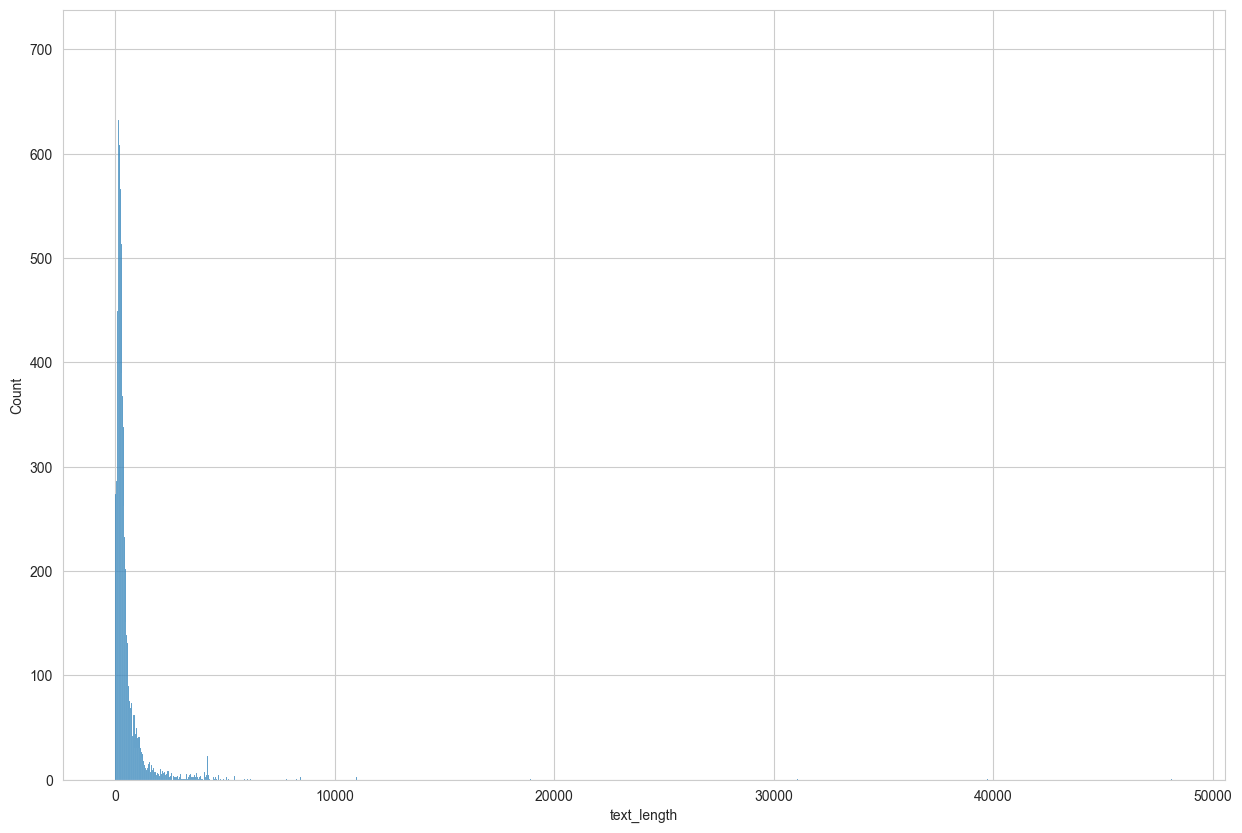

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.histplot(data=data['text_length'])
plt.show()

In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [8]:
print(train_data)

                                                   text    id sentiment  \
4410  *В Казахстане нет места для АЭС\n* Казахстанск...  6464   neutral   
6720  По итогам трех кварталов 2016 года АвтоВАЗ сни...  8774  negative   
6753  \n\nВ Алматы состоялся запуск нового котлоагре...  8807  positive   
3375  Более 25 млн собрано для детей с нарушениями Н...  5429  positive   
3422  Ситуация на валютном рынке в настоящее время о...  5476   neutral   
...                                                 ...   ...       ...   
5734  \n\nВ рамках исполнения поручения Главы госуда...  7788  positive   
5191  Глава МИР РК Женис Касымбек предложил разрешит...  7245   neutral   
5390  Пассажирам "Тулпар-Тальго", встречающим нового...  7444  positive   
860   На правительственном часе по налоговым и тамож...  2914   neutral   
7270  Fitch Ratings-Москва-20 декабря 2016 г. \n \nF...  9324  positive   

      label  text_length  
4410      1          550  
6720      2          464  
6753      0       

# Tokenizing With Rubert-Tiny2

In [9]:
from transformers import BertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny2')


def tokenize_data(data, max_length=512):
    texts = data['text'].tolist()
    tokens = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return tokens


train_tokens = tokenize_data(train_data)
val_tokens = tokenize_data(val_data)

/Users/timoniche/PycharmProjects/NLP/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [10]:
print(train_tokens.input_ids.shape)

torch.Size([6610, 512])


In [11]:
train_dataset = TensorDataset(
    train_tokens['input_ids'],
    train_tokens['attention_mask'],
    torch.tensor(train_data['label'].tolist(), dtype=torch.long),
)

val_dataset = TensorDataset(
    val_tokens['input_ids'],
    val_tokens['attention_mask'],
    torch.tensor(val_data['label'].tolist(), dtype=torch.long),
)

# Loading Rubert-Tiny2 Pretrained

In [12]:
device = 'mps' if torch.backends.mps.is_built() else 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

mps


In [35]:
model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2', num_labels=num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Fine-Tuning Rubert-Tiny2 with CLS token

In [15]:
from torch.utils.data import DataLoader


def run_model_on_loader(
        model,
        loader: DataLoader,
        epoch,
        num_epochs,
        optimizer,
        mode,
):
    total_loss = 0

    for input_ids, attention_mask, labels in tqdm(loader, desc=f'{mode} epoch {epoch}/{num_epochs}...'):
        if mode == 'Training':
            optimizer.zero_grad()

        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        outputs_loss = outputs.loss
        total_loss += outputs_loss.item()

        if mode == 'Training':
            outputs_loss.backward()
            optimizer.step()

    loss = total_loss / len(loader)
    print(f'{mode} epoch {epoch + 1}/{num_epochs}: {mode} Loss: {loss:.4f}')

In [16]:
from tqdm import tqdm


def cls_train(
        model,
        train_loader,
        val_loader,
        optimizer,
        num_epochs=5,
):
    for epoch in range(num_epochs):
        model.train()

        run_model_on_loader(model, train_loader, epoch, num_epochs, optimizer, mode='Training')

        model.eval()

        with torch.no_grad():
            run_model_on_loader(model, val_loader, epoch, num_epochs, optimizer, mode='Validating')

In [25]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)



In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

cls_train(model, train_loader, val_loader, optimizer)

# Running on test json

In [32]:
df = pd.read_json(cur_dir() + '/sentiment-analysis-in-russian/test.json')

print(df)

                                                   text    id
0     Как сообщает пресс-служба акимата Алматы, для ...     0
1     Казахстанские авиакомпании перевозят 250 тысяч...     1
2     На состоявшемся под председательством Касым-Жо...     2
3     В ОАЭ состоялись переговоры между казахстанско...     3
4     12 вагонов грузового поезда сошли с путей в Во...     4
...                                                 ...   ...
2051  На официальной странице общественного движения...  2079
2052  официальный курс – 330,55 тенге за Доллар США ...  2083
2053  «Базовая ставка, которая сейчас составляет 12%...  2084
2054  На начальном этапе за неоплату парковки на при...  2087
2055  Российский авторынок в октябре снизил темпы па...  2088

[2056 rows x 2 columns]


In [33]:
print(df.keys())

Index(['text', 'id'], dtype='object')


In [34]:
tokens = tokenize_data(df)
print(tokens)

{'input_ids': tensor([[    2,  7063, 29679,  ...,     0,     0,     0],
        [    2, 11493,  3095,  ...,     0,     0,     0],
        [    2,  1041, 79778,  ..., 72875,   613,     3],
        ...,
        [    2,   105, 27610,  ...,     0,     0,     0],
        [    2,  1041, 63001,  ...,     0,     0,     0],
        [    2, 33444, 17041,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [35]:
a = tokens.input_ids
print(len(a))
print(len(a[0]))

2056
512


In [36]:
dataset = TensorDataset(
    tokens['input_ids'],
    tokens['attention_mask'],
    torch.tensor(df['id'].tolist(), dtype=torch.long),
)

In [37]:
loader = DataLoader(dataset, batch_size=8, shuffle=False)

In [29]:
def eval_model(model, loader):
    sample = []
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, id in tqdm(loader):
            outputs = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
            )
            logits = outputs.logits
            sentiment = torch.argmax(logits, dim=1).tolist()
            for i in range(len(id)):
                sample.append((id[i].item(), sentiment[i]))

    return sample

In [50]:
sample = eval_model(model, loader)

100%|██████████| 257/257 [00:08<00:00, 31.04it/s]


In [51]:
print(sample)

[(0, 2), (1, 0), (2, 2), (3, 0), (4, 2), (5, 1), (6, 0), (7, 0), (8, 1), (9, 1), (10, 2), (11, 0), (12, 2), (13, 1), (14, 1), (15, 2), (16, 0), (17, 1), (18, 1), (19, 0), (20, 0), (21, 2), (22, 2), (23, 1), (24, 1), (25, 2), (26, 2), (27, 0), (28, 1), (29, 0), (30, 1), (31, 0), (32, 1), (33, 2), (34, 1), (35, 1), (36, 0), (37, 0), (38, 2), (39, 1), (40, 0), (41, 2), (42, 1), (43, 0), (44, 1), (45, 1), (46, 0), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 0), (53, 2), (54, 0), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 0), (63, 0), (64, 1), (65, 0), (66, 2), (67, 1), (68, 0), (69, 2), (70, 0), (71, 0), (72, 1), (73, 1), (74, 1), (75, 0), (76, 1), (77, 0), (78, 0), (79, 0), (80, 1), (81, 2), (82, 0), (83, 0), (84, 0), (85, 1), (86, 0), (87, 2), (88, 1), (89, 0), (90, 0), (91, 1), (92, 1), (93, 1), (94, 0), (95, 0), (96, 2), (97, 0), (98, 2), (99, 0), (100, 0), (101, 1), (102, 1), (103, 2), (104, 1), (105, 2), (106, 1), (107, 0), (108, 2), (109, 1), (110, 0),

In [40]:
label_to_sentiment = {v: k for k, v in sentiment_to_label.items()}


def write_sample_to_file(file, sample):
    with open(file, 'w') as f:
        header = 'id,sentiment'
        print(header, file=f)
        for id, sentiment in sample:
            line = str(id) + ',' + label_to_sentiment[sentiment]
            print(line, file=f)

In [52]:
file = cur_dir() + '/rubert_tiny2.csv'
write_sample_to_file(file, sample)

# Fine-Tuning Rubert-Tiny2 with Avg Aggregation

In [19]:
def mean_pooling(
        token_embeddings: torch.Tensor,
        attention_mask: torch.Tensor
):
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.shape).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [78]:
import torch.nn.functional as F


def avg_train_and_val(
        model,
        loader: DataLoader,
        epoch,
        num_epochs,
        optimizer,
        mode,
):
    total_loss = 0

    for input_ids, attention_mask, labels in tqdm(loader, desc=f'{mode} epoch {epoch}/{num_epochs}...'):
        if mode == 'Training':
            optimizer.zero_grad()

        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        hidden_states = outputs.hidden_states  # 4 x 8 x 512 x 312, encoder_layers_cnt x batch_sz, max_sentence_len, emb_sz
        token_embeddings = hidden_states[-1]  # 8 x 512 x 312, retrieving last encoder layer
        mean_embeddings = mean_pooling(token_embeddings, attention_mask)  # 8 x 312
        logits = model.classifier(mean_embeddings)  # 8 x 3

        outputs_loss = F.cross_entropy(logits, labels)

        total_loss += outputs_loss.item()

        if mode == 'Training':
            outputs_loss.backward()
            optimizer.step()

    loss = total_loss / len(loader)
    print(f'{mode} epoch {epoch + 1}/{num_epochs}: {mode} Loss: {loss:.4f}')

In [79]:
def avg_train(
        model,
        train_loader,
        val_loader,
        optimizer,
        num_epochs=5,
):
    for epoch in range(num_epochs):
        model.train()

        avg_train_and_val(model, train_loader, epoch, num_epochs, optimizer, mode='Training')

        model.eval()

        with torch.no_grad():
            avg_train_and_val(model, val_loader, epoch, num_epochs, optimizer, mode='Validating')

In [80]:
model = BertForSequenceClassification.from_pretrained(
    'cointegrated/rubert-tiny2',
    num_labels=num_labels,
    output_hidden_states=True,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
avg_train(model, train_loader, val_loader, optimizer)

Training epoch 0/5...: 100%|██████████| 827/827 [01:39<00:00,  8.32it/s]


Training epoch 1/5: Training Loss: 0.7912


Validating epoch 0/5...: 100%|██████████| 207/207 [00:05<00:00, 35.13it/s]


Validating epoch 1/5: Validating Loss: 0.6870


Training epoch 1/5...: 100%|██████████| 827/827 [01:37<00:00,  8.51it/s]


Training epoch 2/5: Training Loss: 0.5567


Validating epoch 1/5...: 100%|██████████| 207/207 [00:05<00:00, 35.32it/s]


Validating epoch 2/5: Validating Loss: 0.6552


Training epoch 2/5...: 100%|██████████| 827/827 [01:36<00:00,  8.54it/s]


Training epoch 3/5: Training Loss: 0.3507


Validating epoch 2/5...: 100%|██████████| 207/207 [00:05<00:00, 35.30it/s]


Validating epoch 3/5: Validating Loss: 0.7544


Training epoch 3/5...: 100%|██████████| 827/827 [01:36<00:00,  8.53it/s]


Training epoch 4/5: Training Loss: 0.2343


Validating epoch 3/5...: 100%|██████████| 207/207 [00:05<00:00, 35.07it/s]


Validating epoch 4/5: Validating Loss: 0.8343


Training epoch 4/5...: 100%|██████████| 827/827 [01:36<00:00,  8.54it/s]


Training epoch 5/5: Training Loss: 0.1835


Validating epoch 4/5...: 100%|██████████| 207/207 [00:05<00:00, 35.00it/s]

Validating epoch 5/5: Validating Loss: 0.9723


In [82]:
sample = eval_model(model, loader)

100%|██████████| 257/257 [00:07<00:00, 34.92it/s]


In [83]:
file = cur_dir() + '/meanpooling_rubert_tiny2.csv'
write_sample_to_file(file, sample)